### Explore and validate a DwC archive of animal movement data
Usually we will be working from an OTN-built DwC archive, but any electronically tagged animal movement data DwC archive in Event Core or Occurrence Core should be usable for this purpose.

In [27]:
# ! pip install python-dwca-reader

from dwca.read import DwCAReader
from dwca.darwincore.utils import qualname as qn
import plotly.express as px  # ok plotly do your thing.
import ipywidgets
# mapbox_token = 

# Use requests and the OTN IPT to get a file to work with
import requests

URL = "https://members.oceantrack.org/ipt/archive.do?r=otndalnsbluesharktracking"

r = requests.get(URL)
with open("DwC-a.zip", "wb") as fd:
    fd.write(r.content)



with DwCAReader("DwC-a.zip") as dwca:
    dwca.metadata
    print("Core type is %s" % dwca.descriptor.core.type)
    for e in dwca.descriptor.extensions:
        print('Extension %s present' % e.type)
        
    core_df = dwca.pd_read(dwca.descriptor.core.file_location)
    
    print("Core dataframe has %s rows and %s columns" % core_df.shape)
    
    for e in dwca.descriptor.extensions:
        ext_df = dwca.pd_read(e.file_location, low_memory=False) # large files with mixed-type columns :/ 
        print("Extension %s has %s rows and %s columns" % (e.type, ext_df.shape[0], ext_df.shape[1]))
        if e.type == "http://rs.tdwg.org/dwc/terms/Occurrence":
            occ_df = ext_df

Core type is http://rs.tdwg.org/dwc/terms/Event
Extension http://rs.tdwg.org/dwc/terms/Occurrence present
Extension http://rs.iobis.org/obis/terms/ExtendedMeasurementOrFact present
Core dataframe has 8449 rows and 11 columns
Extension http://rs.tdwg.org/dwc/terms/Occurrence has 6768 rows and 30 columns
Extension http://rs.iobis.org/obis/terms/ExtendedMeasurementOrFact has 510 rows and 10 columns


In [28]:
# Get spatial and temporal extents.
# don't need multiple points at the same locations, drop duplicates
geo_df = core_df[['decimalLatitude', 'decimalLongitude']].drop_duplicates()
print("Reduced %s occurrences to %s distinct locations for the purposes of plotting geographic scope" % (len(core_df), len(geo_df)))
print("Project ranges from %s to %s" % (core_df.eventDate.min(), core_df.eventDate.max()))

# Plot it with plotly express - quick, interactive, coarse coastlines though.
fig = px.scatter_geo(geo_df, lat='decimalLatitude', lon='decimalLongitude')
fig.show()
    

Reduced 8449 occurrences to 1042 distinct locations for the purposes of plotting geographic scope
Project ranges from 2011-03-29 13:33:54 to 2022-11-05 17:53:55


In [29]:
# Lonboard go!
# to install lonboard
# you can pip install lonboard  - new bleeding edge versions here
# or 
# mamba install lonboard   - older but perhaps more stable behaviour.
# depending on your environment preferences.
# This code was written against lonboard 0.4.x

# Tentative plan:
# Make a set of line geometry objects per individual fish 
# and plot using lonboard.
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
# from palettable.colobrewer.diverging import BrBG_10

from lonboard import viz, Map, ScatterplotLayer
import ipywidgets
from lonboard.colormap import apply_continuous_cmap

In [30]:
# if it's Event Core, merge the event/occurrence dataframes
if(dwca.descriptor.core.type == "http://rs.tdwg.org/dwc/terms/Event"):
    print("Combining Event Core location data with Occurrence extension data")
    all_df = pd.merge(core_df, occ_df, on='eventID')
elif(dwca.descriptor.core.type == "http://rs.tdwg.org/dwc/terms/Occurrence"):
    print("Core is Occurrence, skipping join step.")
    all_df = core_df

Combining Event Core location data with Occurrence extension data


In [31]:
all_gdf = gpd.GeoDataFrame(all_df, geometry= gpd.points_from_xy(all_df.decimalLongitude, all_df.decimalLatitude), crs=4326)

In [32]:
all_gdf

,id,eventID,parentEventID,eventDate,fieldNotes,maximumDepthInMeters,decimalLatitude,decimalLongitude,geodeticDatum,coordinateUncertaintyInMeters,...,organismScope,samplingProtocol,startDayOfYear,endDayOfYear,locality,scientificNameID,scientificName,kingdom,vernacularName,geometry
0,otn:OTN.NSBS:NSBS-1250980-2022-08-29-release,otn:OTN.NSBS:NSBS-1250980-2022-08-29-release,NaN,2022-08-29T12:05:00Z,NaN,NaN,44.33321,-63.19537,EPSG:4326,NaN,...,individual,tracking tags,241,241,"~5km off Eastern Passage, Nova Scotia",urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-63.19537 44.33321)
1,otn:OTN.NSBS:NSBS-OTBS-8-2022-08-25-release,otn:OTN.NSBS:NSBS-OTBS-8-2022-08-25-release,NaN,2022-08-25T08:20:00Z,NaN,NaN,44.53333,-63.31667,EPSG:4326,NaN,...,individual,tracking tags,237,237,Nova Scotia,urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-63.31667 44.53333)
2,otn:OTN.NSBS:NSBS-OTBS-7-2022-08-25-release,otn:OTN.NSBS:NSBS-OTBS-7-2022-08-25-release,NaN,2022-08-25T07:24:00Z,NaN,NaN,44.53333,-63.31667,EPSG:4326,NaN,...,individual,tracking tags,237,237,Nova Scotia,urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-63.31667 44.53333)
3,otn:OTN.NSBS:NSBS-OTBS-6-2022-08-24-release,otn:OTN.NSBS:NSBS-OTBS-6-2022-08-24-release,NaN,2022-08-24T08:33:00Z,NaN,NaN,44.53333,-63.33333,EPSG:4326,NaN,...,individual,tracking tags,236,236,Nova Scotia,urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-63.33333 44.53333)
4,otn:OTN.NSBS:NSBS-OTBS-5-2022-08-24-release,otn:OTN.NSBS:NSBS-OTBS-5-2022-08-24-release,NaN,2022-08-24T06:55:00Z,NaN,NaN,44.55000,-63.36667,EPSG:4326,NaN,...,individual,tracking tags,236,236,Nova Scotia,urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-63.36667 44.55000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6762,otn:OTN.WSMBUW:7-VR2AR-547337-2022_07_08T10_NS...,otn:OTN.WSMBUW:7-VR2AR-547337-2022_07_08T10_NS...,otn:OTN.WSMBUW:7-VR2AR-547337-2022_07_08T10,2022-08-22 15:05:21,NaN,NaN,44.37583,-64.04822,EPSG:4326,1000.0,...,individual,acoustic detection,2022-08-22T15,2022-08-22T15,"LINE\ARRAY:MAH_Bay, STATION:7",urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-64.04822 44.37583)
6763,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10_NS...,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10_NS...,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10,2022-08-16 01:36:21,NaN,NaN,44.38088,-64.05565,EPSG:4326,1000.0,...,individual,acoustic detection,2022-08-16T1,2022-08-16T1,"LINE\ARRAY:MAH_Bay, STATION:8",urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-64.05565 44.38088)
6764,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10_NS...,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10_NS...,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10,2022-08-16 02:01:20,NaN,NaN,44.38088,-64.05565,EPSG:4326,1000.0,...,individual,acoustic detection,2022-08-16T2,2022-08-16T2,"LINE\ARRAY:MAH_Bay, STATION:8",urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-64.05565 44.38088)
6765,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10_NS...,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10_NS...,otn:OTN.WSMBUW:8-VR2AR-546836-2022_07_08T10,2022-09-26 02:13:55,NaN,NaN,44.38088,-64.05565,EPSG:4326,1000.0,...,individual,acoustic detection,2022-09-26T2,2022-09-26T2,"LINE\ARRAY:MAH_Bay, STATION:8",urn:lsid:marinespecies.org:taxname:105801,Prionace glauca,Animalia,blue shark,POINT (-64.05565 44.38088)


In [33]:
# What do the individual points look like, maybe scale the radius by detection counts?
# Color code HumanObservations vs MachineObservations?

map_ = viz(all_gdf, radius_min_pixels=3)

In [34]:
map_

Map(layers=[ScatterplotLayer(radius_min_pixels=3.0, table=pyarrow.Table
id: string
eventID: string
parentEvent…

In [35]:
# make a LineString for each individual from the earliest to last date of occurrence
# order by individual and date, then group by?
# or do we make a linestring based on the existing gdf
from shapely.geometry import LineString

# first, drop all single-row elements from the gdf, linestrings hate that shit.
no_single_dets = all_gdf['organismID'].value_counts() > 1
filtered_gdf = all_gdf[all_gdf['organismID'].isin(no_single_dets[no_single_dets].index)]

# then make lines
line_gdf = filtered_gdf.sort_values(by=['organismID','eventDate']).groupby('organismID')['geometry'].apply(lambda x: LineString(x.tolist())).reset_index()

In [36]:
def hex_to_rgb(hex):
    if hex[0] == '#':
        hex = hex[1:] # strip the leading #
    return tuple(int(hex[i:i+2], 16) for i in (0,2,4))



In [37]:
hex_to_rgb('#ffffff')

(255, 255, 255)

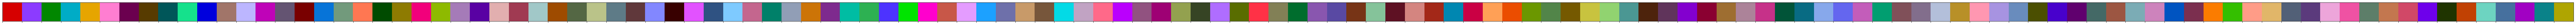

In [19]:
import seaborn as sns
import colorcet as cc


# Many distinct colors for many-individualed datasets, see colorcet.holoviz.org for details
palette = sns.color_palette(cc.glasbey_dark, n_colors=len(line_gdf))

sns.palplot(palette)


In [42]:
colors = [hex_to_rgb(x) for x in np.array(cc.glasbey_dark[0:len(line_gdf)])]
colors = np.array(colors).astype('uint8')

In [54]:
from lonboard import Map, PathLayer, ScatterplotLayer
layer = PathLayer.from_geopandas(line_gdf, auto_downcast=False, width_min_pixels=1)
layer.get_color = colors
capture_layer = ScatterplotLayer.from_geopandas(all_gdf[all_gdf['basisOfRecord']=='HumanObservation'], 
                                                radius_min_pixels=3)
# dimensions were different for HumanObservations somehow than the Line layers... did we have recaptures?
# capture_layer.get_fill_color = colors
map_ = Map(layers=[layer, capture_layer])
map_

Map(layers=[PathLayer(get_color=<pyarrow.lib.FixedSizeListArray object at 0x15bdb4b80>
[
  [
    214,
    0,
 …

In [49]:
## Isolate an individual

from lonboard import Map, PathLayer, ScatterplotLayer
indiv='NSBS-SWAANTJE'
layer = PathLayer.from_geopandas(line_gdf[line_gdf['organismID']==indiv], auto_downcast=False, width_min_pixels=1)
layer.get_color = colors[line_gdf[line_gdf['organismID']==indiv].index]
capture_layer = ScatterplotLayer.from_geopandas(all_gdf[(all_gdf['organismID']==indiv) & 
                                            (all_gdf['basisOfRecord']=='HumanObservation')], 
                                                radius_min_pixels=3)
map_ = Map(layers=[layer, capture_layer])
# also print the HumanObservations of this individual - usually the tagging event in a dataset like this one.
print(all_gdf[((all_gdf['organismID']==indiv) & (all_gdf['basisOfRecord']=='HumanObservation'))])
map_

                                    id                             eventID  \
96  otn:OTN.NSBS:NSBS-SWAANTJE-release  otn:OTN.NSBS:NSBS-SWAANTJE-release   

   parentEventID             eventDate fieldNotes  maximumDepthInMeters  \
96           NaN  2015-07-14T00:00:00Z        NaN                   NaN   

    decimalLatitude  decimalLongitude geodeticDatum  \
96         44.21995         -63.18294     EPSG:4326   

    coordinateUncertaintyInMeters  ... organismScope samplingProtocol  \
96                            NaN  ...    individual    tracking tags   

   startDayOfYear endDayOfYear                      locality  \
96            195          195  Eastern Passage, Nova Scotia   

                             scientificNameID   scientificName   kingdom  \
96  urn:lsid:marinespecies.org:taxname:105801  Prionace glauca  Animalia   

   vernacularName                    geometry  
96     blue shark  POINT (-63.18294 44.21995)  

[1 rows x 41 columns]


Map(layers=[PathLayer(get_color=<pyarrow.lib.FixedSizeListArray object at 0x15c32f220>
[
  [
    52,
    191,
…

### 